In [1]:
import sys, os
PROJECT_ROOT = r"D:\bhermosi\chestxsim-project"   # <- adjust to your real path
SRC = os.path.join(PROJECT_ROOT, "src")
if SRC not in sys.path:
    sys.path.insert(0, SRC)

# Projection Module — Usage Guide 

This notebook introduces the **projection** module in ChestXSim and how to use it in practice. It shows how to:
- Use the **ASTRA wrapper** to simulate Digital Chest Tomosynthesis (DCT) projections - using attenuation volume or density volumes per tissue types
- Add **physical effects** (spectrum, ISL, flood/log, noise) as processing steps.
- Integrate all steps into a **`Pipeline`** or use it indepently. 


### Overview 

The **projection module** provides the tools to simulate X-ray measurements consistent with the **Digital Chest Tomosynthesis (DCT)** geometry, where the **X-ray source moves vertically** and the **detector remains stationary**.  
It separates **purely geometrical operations** (forward and backprojection) handled by the **ASTRA wrapper** from **physical effects** such as spectrum, inverse-square-law, flood/log correction, and noise — implemented as **processing steps**.

## Available Steps in the Projection Module
> **Reminder:** Steps are **callers**: they take a `volumeData`, apply the transform, and log parameters in `metadata.step_outputs`.  
> Use them **individually** or **chained** in a `Pipeline`.
 
| Step class | Purpose | Key parameters |
|-------------|----------|----------------|
| **`Projection`** | Performs 3D forward projection using a defined operator (e.g., `Astra_Tomo`). | `opt`, `channel_wise` |
| **`SpectrumEffect`** | Applies X-ray spectrum, ISL, flood/log correction to projections. | `source`, `ISL`, `apply_flood_correction`, `log` |
| **`NoiseModel`** | Adds Poisson and Gaussian (dark) noise to simulated projections. | `mu_dark`, `sigma_dark`, `inhomgeneities_map`, `log` |


### The Operator (`opt`)

At the core of the `Projection` step is the **operator** `opt`: a wrapper instance  that exposes a unified API:
- `forward_operator(volume3d, voxel_size)` → projections `(W, H, Angles)`
- `adjoint_operator(projs, reco_dim, reco_vx_size)` → backprojection `(W, H, D)`

The **`Astra_OP`** class is the **abstract base wrapper** for ASTRA within ChestXSim.  
It defines the common methods for initializing geometry, allocating ASTRA projectors, and managing GPU execution.

The **`Astra_Tomo`** is the **concrete implementation** for **Digital Chest Tomosynthesis (DCT)**, initialized with a `TomoGeometry` object that specifies the system geometry.  

Internally, `Astra_Tomo` sets up and manages **ASTRA’s 3D cone-beam projection geometry**, which includes creating the ASTRA projector and calling the appropriate CUDA-accelerated routines:

- **Forward projection:** `FP3D_CUDA`  
- **Backprojection:** `BP3D_CUDA`

### Initialize a concrete operator (ASTRA + DCT)

In [2]:
from chestxsim.core.geometries import TomoGeometry
from chestxsim.wrappers.astra import Astra_Tomo

# Geometry (DCT)
geo = TomoGeometry(
    detector_size=(4288, 4288),
    pixel_size=(0.1, 0.1),
    binning_proj=8,
    SDD=1800.0,
    bucky=14.47,
    step=16.077,
    nstep=60
)

# Create the concrete operator from geometry
opt = Astra_Tomo(geometry=geo)


### print some atributes here 

GPU detected: Using CuPy with 1 device(s), current device: 0


### Generate Projections directly from an array 
Now, you can use the configured operator **directly on an array** to generate projections from a 3D volume:

Projections: (536, 536, 61)


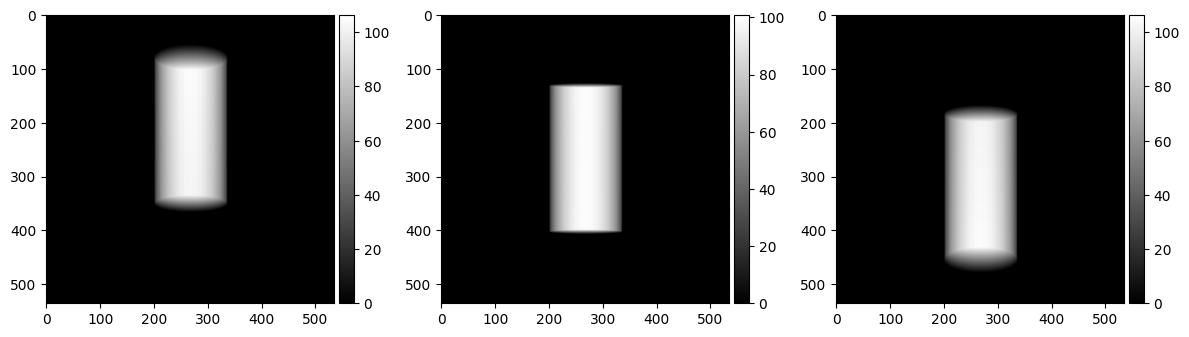

In [3]:
from chestxsim.core  import xp
from chestxsim.utility  import plot

# Example phantom (W,H,D): solid cylinder
W, H, D = 256, 256, 200
X, Y = xp.meshgrid(xp.arange(W), xp.arange(H), indexing="ij")
cyl = ((X - W/2)**2 + (Y - H/2)**2) <= (50**2)
vol = xp.broadcast_to(cyl[..., None], (W, H, D)).astype(xp.float32)

voxel_size = (1.0, 1.0, 1.0) 

projs = opt.forward_operator(vol, voxel_size)
print("Projections:", projs.shape)

plot(projs.get()[:, :, 0].T, projs.get()[:, :, 30].T, projs.get()[:, :, 60].T)

> **Note**: The first projection corresponds to the topmost source position, the middle to the central position, and the last to the bottom position along the vertical trajectory followed by the source. 

### Use the Projection Step with volumeData
Alternatively, the `Projection`step operates directly on a `VolumeData` object. It is configured with the operator and can project either:
- The **single attenuation volume** (`channel_wise=False`), or 
- **Per-tissue channels** (`channel_wise=True`), when projecting tissue-separated density volumes. 


[RawReader] Found tissue 'bone' at D:\bhermosi\chestxsim-project\test\volumes\CT_converted\density\bone\NODULO_S18_S20
[RawReader] Found tissue 'soft' at D:\bhermosi\chestxsim-project\test\volumes\CT_converted\density\soft_tissue\NODULO_S18_S20
{'detector_size': (4288, 4288), 'pixel_size': (0.1, 0.1), 'binning_proj': 8, 'SDD': 1800.0, 'bucky': 14.47, 'step': 16.077, 'nstep': 60}
{'detector_size': (4288, 4288), 'pixel_size': (0.1, 0.1), 'binning_proj': 8, 'SDD': 1800.0, 'bucky': 14.47, 'step': 16.077, 'nstep': 60}
Attenuation projections: (536, 536, 61, 1)
Density projections: (536, 536, 61, 2)
Projection of the attenuation volume


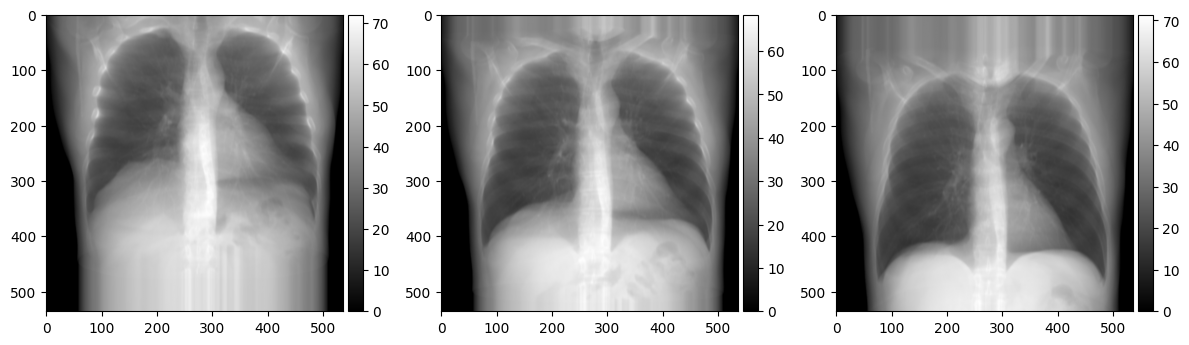

Bone projections


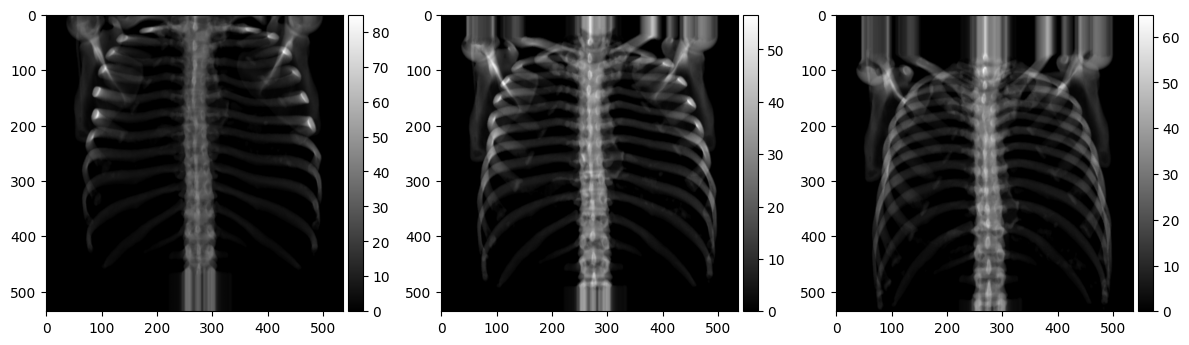

Soft tissue projections


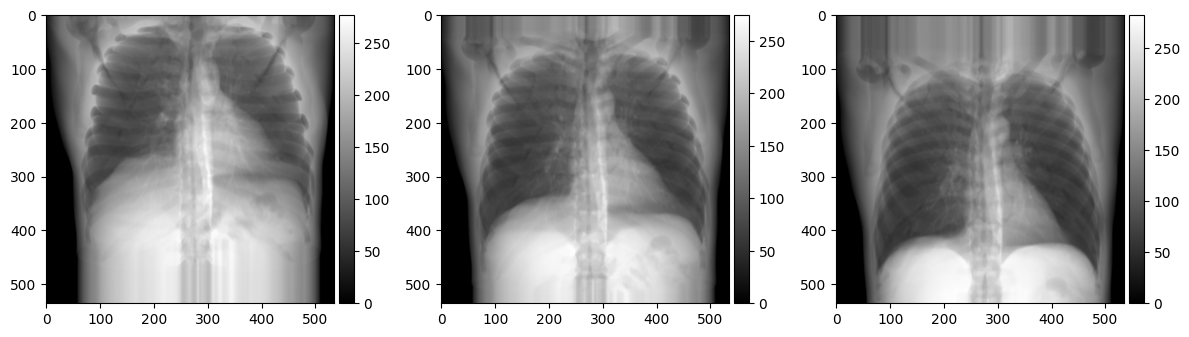

In [4]:
from chestxsim.io import RawReader
from chestxsim.projection.steps import Projection
from chestxsim.utility import plot
from pathlib import Path 

# --- Initialize the reader ---
reader = RawReader()

base_path= Path(r"D:\bhermosi\chestxsim-project\test\volumes\CT_converted")
case_id = "NODULO_S18_S20"

# --- Load single-channel attenuation volume (μ) ---
att_vol = reader.read( base_path/ "mus"/ case_id)

# --- Load multi-tissue density volume (stacked channels: bone, soft, etc.) ---
density_vol = reader.load_multi_tissue(base_path/"density", case_id, combine_method="stack")

# --- Project volumes
att_proj = Projection(opt, channel_wise=False)(att_vol)
density_proj = Projection(opt, channel_wise=True)(density_vol)

print("Attenuation projections:", att_proj.volume.shape)
print("Density projections:", density_proj.volume.shape)

print("Projection of the attenuation volume")
plot(
    att_proj.volume.get()[:, :, 0, 0].T,   
    att_proj.volume.get()[:, :, 30, 0].T,    
    att_proj.volume.get()[:, :, 60, 0].T     
)
print("Bone projections")
plot(
    density_proj.volume.get()[:, :, 0, 0].T,     
    density_proj.volume.get()[:, :, 30, 0].T,    
    density_proj.volume.get()[:, :, 60, 0].T     
)

print("Soft tissue projections")
plot(
    density_proj.volume.get()[:, :, 0, 1].T,     
    density_proj.volume.get()[:, :, 30, 1].T,    
    density_proj.volume.get()[:, :, 60, 1].T     
)

> **Note**: Step details are automatically tracked in metadata, so you can review at any time all the steps recorded so far — both the preprocessing steps and the new projection step that has just been applied. This makes it easy to trace the full simulation chain and check parameters were consistently applied across the workflow ...

In [5]:
density_proj.metadata.show_steps()


--- Simulation Steps ---
original_input_units: HU
clip_values: [-1000, 3000]
BedRemover: {'bed_removed': True, 'method': 'analytical'}
AirCropper: {'axis': 1, 'crop_indices': [61, 412]}
VolumeExtender: {'extension_mm': [100, 100]}
TissueSegmenter: {'tissue_segmented': True, 'method': 'analytical', 'tissue_types': ['bone', 'soft']}
UnitConverter: {'units': 'density', 'e_eff': 47.3, 'mac_eff_water': 0.23617, 'tissue_type': ['bone', 'soft'], 'mu_factor': 1.0}
Projection: {'kernel': 'Astra_Tomo', 'geometry': {'detector_size': (4288, 4288), 'pixel_size': (0.1, 0.1), 'binning_proj': 8, 'SDD': 1800.0, 'bucky': 14.47, 'step': 16.077, 'nstep': 60}}


### Add Physical Effects 

The **`PhysicsEffect`** step models the **Beer–Lambert law** and related X-ray physical effects that occur during acquisition.  
It converts projected density maps into realistic **intensity projections**, accounting for both beam spectrum and loss of intensity with distance due to the inverse-square law (ISL) following:


$$
I_{\text{raw}}(r) \;=\; \sum_i \frac{I_0}{d(r)^2}\, S(\varepsilon_i)\, \exp\!\Big(-\sum_t \mu_t(\varepsilon_i, r)\Big)
$$

with
$$
\mu_t(\varepsilon_i, r) \;=\; \mathrm{MAC}_t(\varepsilon_i)\, p_t(r),
$$

This step can also apply **flood-field normalization** and compute the **log-attenuation image**, as commonly done in raw detector preprocessing. 

> **Note**: 
`PhysicsEffect` expects input projections derived from **density-based volumes** (units="density").

| Parameter | Description |
|------------|-------------|
| **`source`** | Instance of `SourceSpectrum` defining the X-ray beam intensity (`I0`), tube voltage (`kVp`), and mode (`poly_flag=True/False`). |
| **`ISL`** | Enables the **inverse-square-law** correction. If `True`, scaling is applied to the X-ray beam intensity according to distance from source to pixel. |
| **`apply_flood_correction`** | If `True`, normalizes the raw projections by the computed or provided flood field. |
| **`flood`** | Optional pre-acquired flood-field image (array). If `None`, it is computed theoretically from the spectrum. |
| **`log`** | If `True`, applies the `-log(I / I0)` transform to obtain projections. |

In [ ]:
from chestxsim.projection.steps import PhysicsEffect
from chestxsim.core.data_containers import SourceSpectrum

# Base source: polychromatic 120 kVp
poly_src = SourceSpectrum(I0=1e5, voltage=120, poly_flag=True)

# A) Log-attenuation with flood correction
phys_log = PhysicsEffect(
    source=poly_src,
    ISL=False,                   # spectrum only
    apply_flood_correction=True, # normalize by flood
    flood=None,                  # Auto-compute if not provided
    log=True                     # Output log-attenuation image
)
projs_log = phys_log(density_proj)

# B) Linear intensity (no log), still flood-corrected for fair comparison
phys_lin = PhysicsEffect(
    source=poly_src,
    ISL=False,
    apply_flood_correction=False,
    flood=None,
    log=False                    # keep linear intensities
)
projs_lin = phys_lin(density_proj)

print("Log proj shape:", projs_log.volume.shape, "| Linear proj shape:", projs_lin.volume.shape)

Tissue found: bone at channel 0
Tissue found: soft at channel 1
[MAC] Base folder for MACs: D:\bhermosi\chestxsim-project\materials\mac
[SourceSpectrum] Reading X-ray spectrum from D:\bhermosi\chestxsim-project\materials\spectra\spectr120kVp.mat
Tissue found: bone at channel 0
Tissue found: soft at channel 1
[MAC] Base folder for MACs: D:\bhermosi\chestxsim-project\materials\mac
Log proj shape: (536, 536, 61) | Linear proj shape: (536, 536, 61)


Linear intensity (no log), still flood corrected


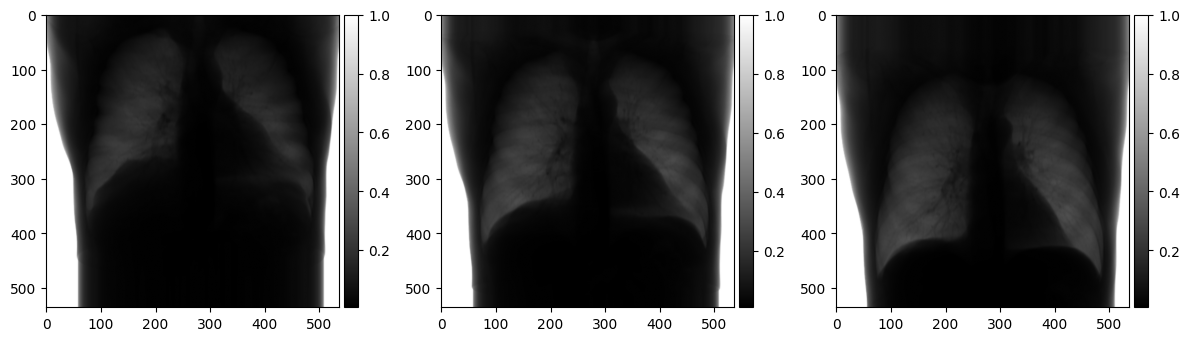

Log-attenuation (flood correction)


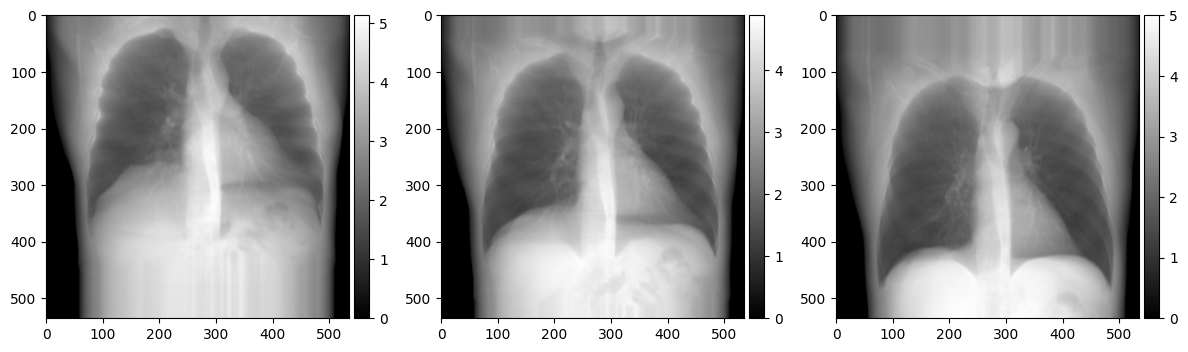

In [7]:
from chestxsim.utility import plot

# -- Visualize Linear vs log-attenuation 
print("Linear intensity (no log), still flood corrected")
plot(
    projs_lin.volume.get()[:, :, 0].T,
    projs_lin.volume.get()[:, :, 30].T, 
    projs_lin.volume.get()[:, :, 60].T
)
print("Log-attenuation (flood correction)")
plot(
    projs_log.volume.get()[:, :, 0].T,
    projs_log.volume.get()[:, :, 30].T, 
    projs_log.volume.get()[:, :, 60].T
)

**Variants and options**

**Polychromatic vs Monochromatic simulation**

In [8]:
# Polychromatic (already computed above): projs_log (120 kVp)
# Monochromatic source at an effective energy (e.g., 70 keV)
mono_src = SourceSpectrum(I0=1e5, voltage=120, poly_flag=False, effective_energy=55)

phys_mono = PhysicsEffect(
    source=mono_src,
    ISL=False,
    apply_flood_correction=True,
    flood=None,
    log=True
)
projs_mono = phys_mono(density_proj)
print("Mono proj shape:", projs_mono.volume.shape)


Tissue found: bone at channel 0
Tissue found: soft at channel 1
[MAC] Base folder for MACs: D:\bhermosi\chestxsim-project\materials\mac
[SourceSpectrum] Reading X-ray spectrum from D:\bhermosi\chestxsim-project\materials\spectra\spectr120kVp.mat
Mono proj shape: (536, 536, 61)


Projections using a Polychromatic X-Ray Source


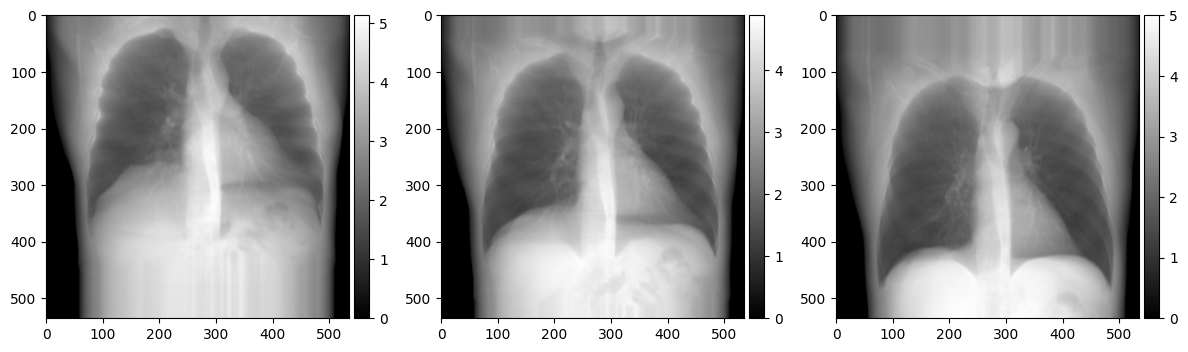

Projections using a Monochromatic X-Ray Source


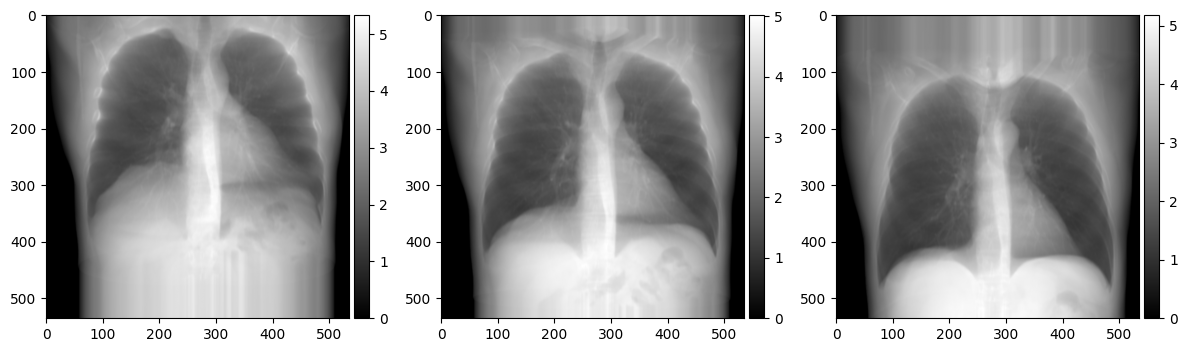

Absolute difference (|poly − mono|)


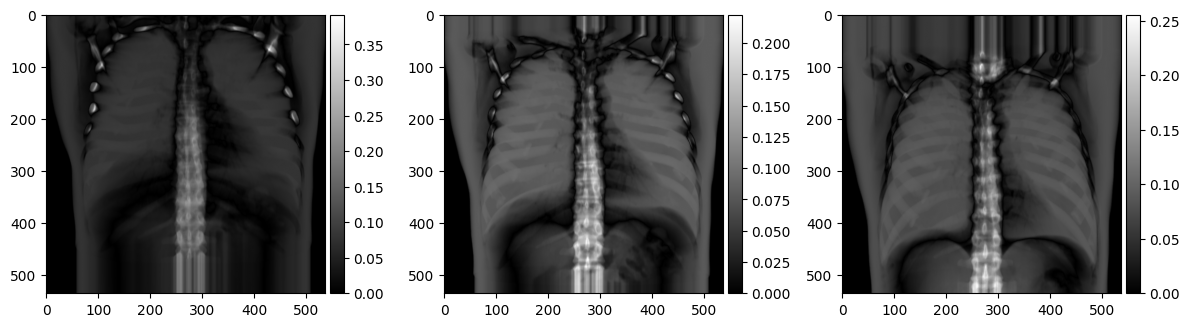

In [9]:
# -- Visualize 
print("Projections using a Polychromatic X-Ray Source")
plot(
    projs_log.volume.get()[:, :, 0].T,
    projs_log.volume.get()[:, :, 30].T, 
    projs_log.volume.get()[:, :, 60].T
)
print("Projections using a Monochromatic X-Ray Source")
plot(
    projs_mono.volume.get()[:, :, 0].T,
    projs_mono.volume.get()[:, :, 30].T, 
    projs_mono.volume.get()[:, :, 60].T
)
print("Absolute difference (|poly − mono|)")
diff_abs = xp.abs(projs_mono.volume - projs_log.volume  )
plot(
    diff_abs.get()[:, :, 0].T,
    diff_abs.get()[:, :, 30].T,
    diff_abs.get()[:, :, 60].T
)

> **Note (beam hardening):** The **polychromatic** case exhibits energy-dependent attenuation that leads to **beam-hardening effects**. These are most evident **after reconstruction**, often visible as **cupping** or **hypointense bands** between dense structures (e.g., bones). The monochromatic case serves as a reference without beam-hardening.

**HACER EL CASO MONOCROMATICO**  


### Consider X-Ray Beam Loss of Intensity (Inverse-Square Law)

In real X-ray systems, the intensity reaching each detector pixel decreases with the **square of the distance** between the source and detector.This geometric fall-off follows the **inverse-square law (ISL)**

The **`PhysicsEffect`** step can include this effect automatically when `ISL=True`.  
It reads the geometry parameters from metadata (created during the `Projection` step) and computes a **distance map** that scales the detected intensity accordingly.

The figure below shows the **distance map** computed for three different source positions in the DCT trajectory.


Nominal Source–Detector Distance from system: 1800.0
Detector size:  (0.1, 0.1)
Detector pixel size:  (0.1, 0.1)


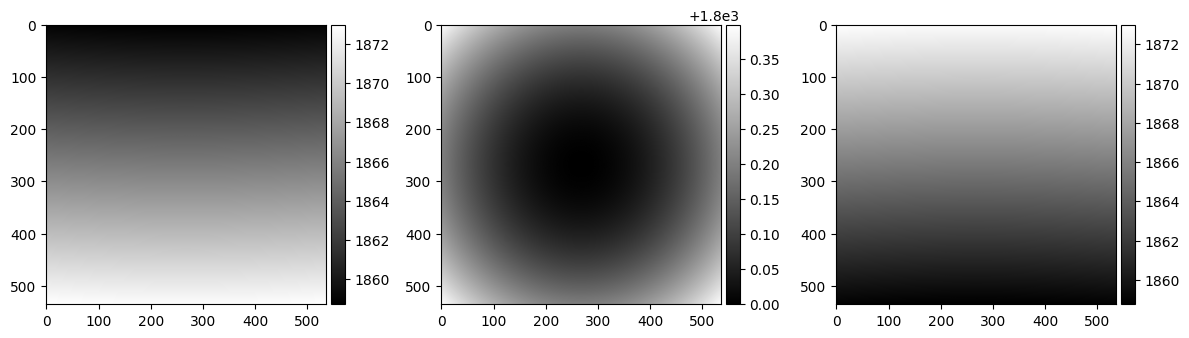

In [10]:
import chestxsim.projection.functional as F

# --- Reuse the same TomoGeometry instance defined previously ---
d = F.get_distance_map(geo)
print("Nominal Source–Detector Distance from system:", geo.SDD)
print("Detector size: ", geo.pixel_size)
print("Detector pixel size: ", geo.pixel_size)
plot(d.get()[:, :, 0].T, d.get()[:, :, 30].T, d.get()[:, :, 60].T)

Tissue found: bone at channel 0
Tissue found: soft at channel 1
[MAC] Base folder for MACs: D:\bhermosi\chestxsim-project\materials\mac
Tissue found: bone at channel 0
Tissue found: soft at channel 1
[MAC] Base folder for MACs: D:\bhermosi\chestxsim-project\materials\mac


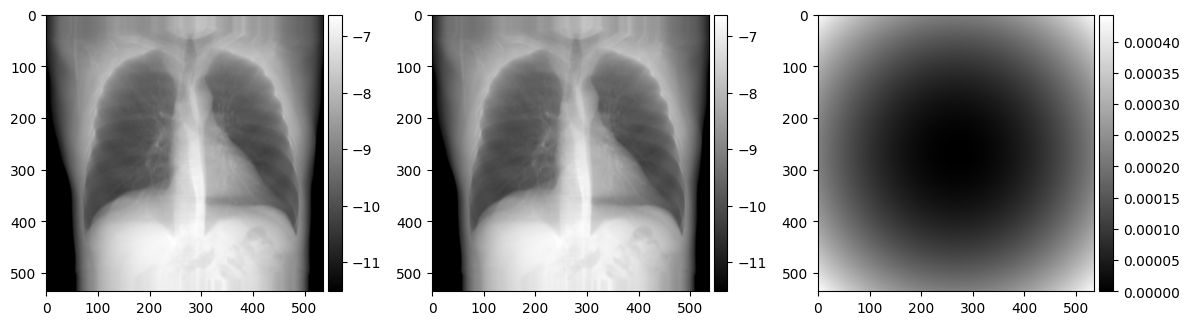

In [11]:
proj_no_isl = PhysicsEffect(source=poly_src, ISL=False, log=True)(density_proj)
proj_with_isl = PhysicsEffect(source=poly_src, ISL=True, log=True)(density_proj)

diff = proj_with_isl.volume - proj_no_isl.volume
plot(
    proj_no_isl.volume.get()[:, :, 30].T,
    proj_with_isl.volume.get()[:, :, 30].T,
    diff.get()[:, :, 30].T
    )  # middle projection


**Add Noise Effect**

Simulates a mixed **Poisson–Gaussian** detector noise model and optional **non-uniform gain** (fixed-pattern inhomogeneities).  

The `NoiseEffect` step can add:
- **Poisson (quantum) noise** — depends on incident intensity (**higher `I0` → lower noise**).
- **Gaussian (dark) noise** — readout/dark-current; set via `mu_dark`, `sigma_dark`, or pass a measured `dark_volume`.
- **Inhomogeneities (gain map)** — pixel-wise multiplicative pattern (e.g., bands, vignetting).
- **Flood/log correction** — optional flat-field normalization and `-log()` to line integral

### Poisson noise
The `NoiseEffect` step internally calls the Poisson generator (equivalent to `F.get_Poisson_component`) using the **linear** projections you provide.  
Below we compare **high-I0** vs **low-I0** with **Poisson-only** (no Gaussian), and display **log** outputs for visibility.

Tissue found: bone at channel 0
Tissue found: soft at channel 1
[MAC] Base folder for MACs: D:\bhermosi\chestxsim-project\materials\mac
[SourceSpectrum] Reading X-ray spectrum from D:\bhermosi\chestxsim-project\materials\spectra\spectr80kVp.mat
Tissue found: bone at channel 0
Tissue found: soft at channel 1
[MAC] Base folder for MACs: D:\bhermosi\chestxsim-project\materials\mac
[SourceSpectrum] Reading X-ray spectrum from D:\bhermosi\chestxsim-project\materials\spectra\spectr80kVp.mat
Poisson noise — high I0 (smoother) vs low I0 (grainier)


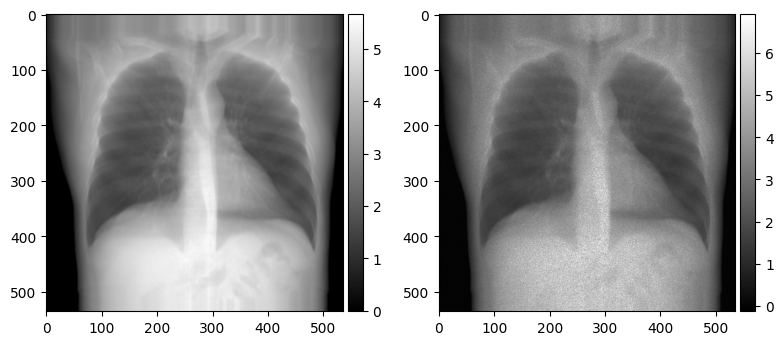

In [ ]:
from chestxsim.projection.steps import NoiseEffect

# --- Linear projections (spectrum only, no ISL, no log) ---
src_high = SourceSpectrum(I0=1e5, voltage=80, poly_flag=True)
src_low  = SourceSpectrum(I0=1e3, voltage=80, poly_flag=True)

proj_high_lin = PhysicsEffect(source=src_high)(density_proj) # no flood correction, no log 
proj_low_lin  = PhysicsEffect(source=src_low)(density_proj)

# --- Poisson-only noise (mu_dark/sigma_dark = 0 → no extra Gaussian) ---
poisson_only = NoiseEffect(mu_dark=0.0, sigma_dark=0.0,
                           dark_volume=None, apply_flood_correction=True,
                           log=True)   # set log=True so we can see grain structure

noisy_high = poisson_only(proj_high_lin)
noisy_low  = poisson_only(proj_low_lin)

print("Poisson noise — high I0 (smoother) vs low I0 (grainier)")
plot(
    noisy_high.volume.get()[:, :, 30, 0].T,   # mid angle
    noisy_low.volume.get()[:, :, 30, 0].T
)

> **Note:** Quantum noise is **signal-dependent**. With **higher `I0`**, the log image looks smoother;  
with **lower `I0`**, it looks grainier — especially in **high-attenuation regions** (e.g., bone) rather than air.

**Poisson + Gaussian Noise**

Gaussian component is compouted by get_Gaussian_component()

Clean log (reference) vs Poisson+Gaussian (high I0)


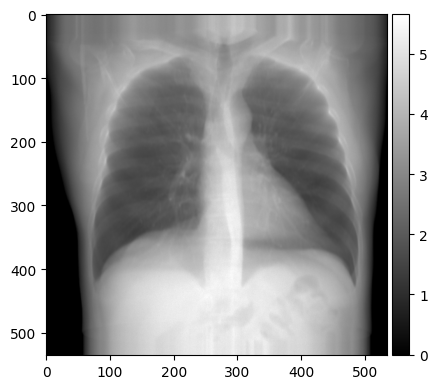

In [23]:
# Add Gaussian dark noise on top of Poisson (use the same high-I0 linear input)
poisson_plus_gauss = NoiseEffect(
    mu_dark=5.0, sigma_dark=6.0,    # Gaussian dark stats
    dark_volume=None,
    apply_flood_correction=True,
    log=True
)

noisy_high_pg = poisson_plus_gauss(proj_high_lin)

print("Clean log (reference) vs Poisson+Gaussian (high I0)")
 
plot(
    noisy_high_pg.volume.get()[:, :, 30, 0].T
)
